# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Multinomial Naive-Bayes
* Linear SVM with SGD training
* Linear SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* ~~n-grams~~
* ~~tunning svm~~
* ~~combine bow and handcrafted features~~
* ~~handcrafted linguistic features~~
* ~~hyperparamater tunning; validation~~


**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [1]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

start_time = time.time()

## Experiments

## Subsets:
* Viral
* All

### Feature engineering
* bow: binary bag of words
* tfidf: term frequency–inverse document frequency
* max_features: limits to 500

### Pre-processing
* processed: convert url in just the domain, separate emojis, remove punctuation, downcase, lemmatization, remove stop words

### Data balancing
* smote: Synthetic Minority Oversampling Technique
* undersampling: random undersampling
* random_oversampling


### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach
* Better results are achivied when using unigrams, bigrams and trigrams

In [2]:
base = '2018'
subset = 'viral'

In [3]:
data_dir = 'data/' + str(base) #+ '/vis_processed_texts.p'
pre_processed = False # the texts were already pre-processed
processed_texts_filename = 'processed_texts-'+subset+'.p'
for filename in os.listdir(data_dir):
    print(filename)
    if filename == processed_texts_filename:
        preprocessed = True
preprocessed     

vis_processed_texts.p
processed_texts-viral.p
processed_texts.p
fakeWhatsApp.BR_2018-handcrafted_features.csv 
fakeWhatsApp.BR_2018.csv
wpp_labels - original midia.csv


True

# Begin experiment

In [4]:
experiment = 'ml-tfidf-unibitri_gram-random_oversampling'
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
validation_mlp = False
df = pd.read_csv(filepath)

if subset == 'viral':
    df = df[df['viral']==1]
df = df[df['midia']==0]    
df.head(5)


/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
15,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1


In [5]:
for m in df[df['misinformation']==1]['text'].unique()[0:100]:
    print()
    print(m)
    print()
    print('..................................')


No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.

..................................

Como são as coisas.
Chefe do jacaré aparece no video baleado e pessoal no video falando que é morador, falam muita merda tentando colocar as forças armadas como vilão.
Quando chegou no hospital foi reconhecido e preso pela PM.

..................................

*No Ceará, o Comando Vermelho( CV ) PROIBIU propaganda de BOLSONARO  nos territórios que* *"administra"*
*Somente LULA E CIRO Podem.  Por serem aliados do CRIME.*
Alguém tem dúvida agora da quadrilha?  

https://www.opovo.com.br/jornal/reportagem/2018/08/a-interferencia-das-faccoes-criminosas-no-processo-eleitoral.html

*Agora é oficial*

..................................

Como falar que o cara não pode ser presidente se em 27 minutos ele:
- lembrou que o bonner levou chifre
- que bonner ganha 4x mais que a Renata
- Mostrou que o kit gay pode ser usado na escola mas não mostrado na TV 22h d

In [6]:
for m in df[df['misinformation']==0]['text'].unique()[0:100]:
    print()
    print(m)
    print()
    print('..................................')


O Bolsonaro tem que estar preparado pra responder assim...

..................................

Devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política,agora so mulheres bonitas...

..................................

EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM NESTE LINK VOTE E ESCOLHA SEU CANDIDATO A PRESIDENTE E COMPARTILHEM AO MAXIMO NAS REDES SOCIAIS DE NORTE A SUL DE LESTE A OESTE , INDIFERENTE DE SUA IDEOLOGIA 

*Detalhe:Vc não consegue votar 2 vezes ou mais.*

https://www.opinionstage.com/palmelonews1/em-quem-vc-vota-para-presidente

..................................

A ratoeira funcionou mais a ratazana aguentou a dor calada kkkkkkkk

..................................

Duas das maiores potências em vendas no Mundo, Coca Cola e Havaianas, se uniram para a maior campanha educacional visando a redução da criminalidade no país.

..................................

Relaxando no sofá, barriguinha plusize, 9mm na cintura, sem coldre, no pelo, com sa

# Corpus statistics

In [7]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,20872.000000,20872.000000,20872.000000
mean,530.377252,80.396560,11.232177
std,901.760873,138.349054,16.071484
min,23.000000,6.000000,2.000000
25%,108.000000,16.000000,2.000000
50%,202.000000,30.000000,5.000000
75%,482.000000,77.000000,12.000000
max,15683.000000,2664.000000,91.000000


In [8]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


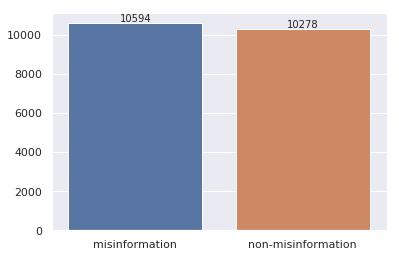

In [9]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


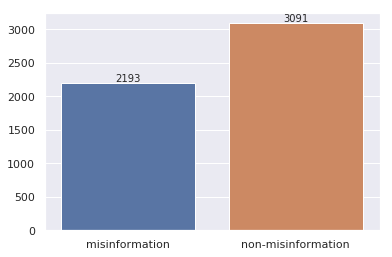

In [10]:
#removing duplicates
    
df = df.drop_duplicates(subset=['text'])    
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [11]:
print(len(texts))
print(len(y))

5284
5284


In [12]:
def avgSizeWords(string):
    list_string = string.split()
    chars = np.array([len(s) for s in list_string])
    return chars.mean()
    
    
t = 'olá, eu sou goku'
avgSizeWords(t)

3.25

In [13]:

    

df['types'] = [len(set(t.split())) for t in df['text']]
df['types/token ratio'] = df['types']/df['words']
df['char/word ratio'] = df['characters']/df['words']
df['average chars by word'] = [avgSizeWords(t) for t in df['text']]

In [14]:
print('basic statistics: misinformation')
df[df['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].describe()

basic statistics: misinformation


,words,types,types/token ratio,characters,char/word ratio,average chars by word,sharings
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,106.556772,73.787506,0.855165,674.312358,6.727408,5.669311,4.830825
std,169.316336,97.796342,0.135726,1047.573011,2.358376,2.001328,6.816556
min,6.000000,1.000000,0.010000,31.000000,4.000000,3.076923,2.000000
25%,18.000000,17.000000,0.760606,122.000000,5.714286,4.705882,2.000000
50%,34.000000,31.000000,0.892857,222.000000,6.142857,5.129771,3.000000
75%,116.000000,88.000000,0.966667,757.000000,6.713235,5.696403,5.000000
max,2203.000000,998.000000,1.000000,13007.000000,61.925000,23.833333,91.000000


In [15]:
print('basic statistics: non-misinformation')
df[df['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].describe()

basic statistics: non-misinformation


,words,types,types/token ratio,characters,char/word ratio,average chars by word,sharings
count,3091.000000,3091.000000,3091.000000,3091.000000,3091.000000,3091.000000,3091.000000
mean,51.279198,38.030087,0.912381,350.283727,7.277105,6.242654,3.325137
std,126.282606,66.444132,0.116137,827.712760,3.343232,3.278133,3.909669
min,6.000000,2.000000,0.003704,23.000000,2.560284,1.524823,2.000000
25%,11.000000,11.000000,0.862879,80.000000,5.584770,4.600000,2.000000
50%,20.000000,19.000000,0.947368,148.000000,6.166667,5.166667,2.000000
75%,44.000000,38.000000,1.000000,298.000000,7.431677,6.350926,3.000000
max,2664.000000,1179.000000,1.000000,15683.000000,46.615385,45.692308,86.000000


In [16]:
mis = df[df['misinformation']==1][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].mean().to_frame().rename(columns={0: "misinformation"})
non_mis = df[df['misinformation']==0][['words','types','types/token ratio' ,'characters', 'char/word ratio', 'average chars by word','sharings']].mean().to_frame().rename(columns={0: "non-misinformation"})
mis.join(non_mis, lsuffix='_misinformation', rsuffix='_non-misinformation')

,misinformation,non-misinformation
words,106.556772,51.279198
types,73.787506,38.030087
types/token ratio,0.855165,0.912381
characters,674.312358,350.283727
char/word ratio,6.727408,7.277105
average chars by word,5.669311,6.242654
sharings,4.830825,3.325137


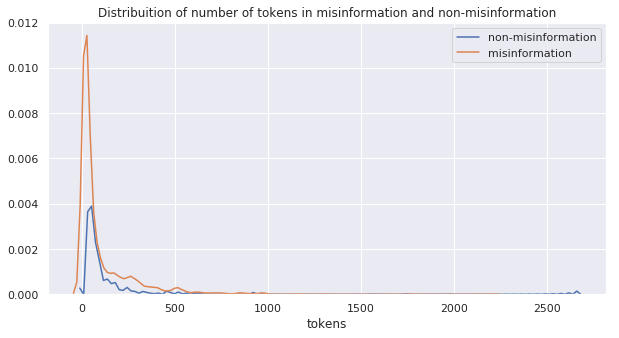

In [17]:
df['tokens'] = df['words']
plt.figure(figsize=(10, 5))

plt.title('Distribuition of number of tokens in misinformation and non-misinformation')
sns.distplot(df[df['misinformation']==0]['tokens'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df[df['misinformation']==1]['tokens'], hist = False, kde = True, label = 'misinformation')
plt.show()

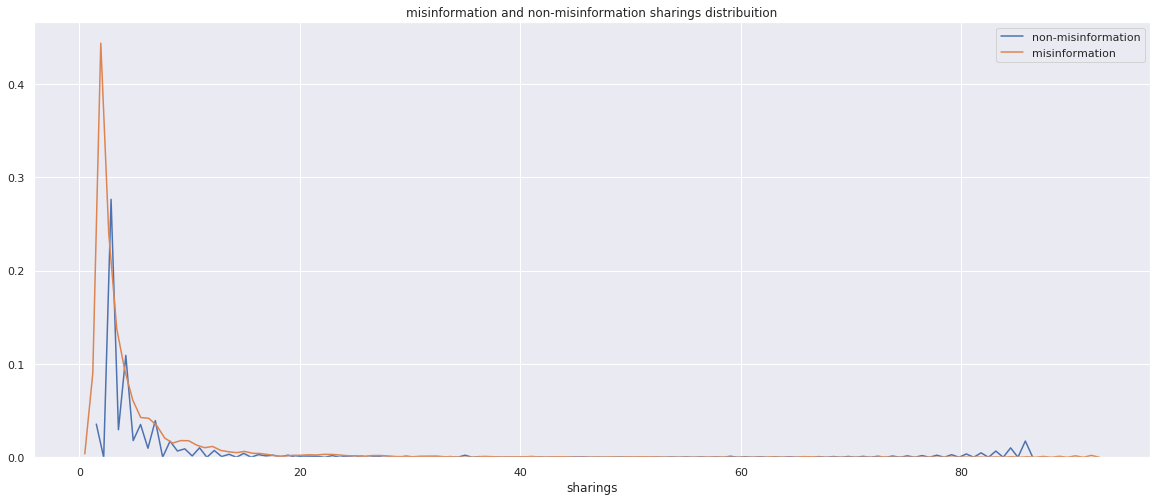

In [18]:
plt.figure(figsize=(20, 8))
plt.title('misinformation and non-misinformation sharings distribuition')
sns.distplot(df[df['misinformation']==0]['sharings'], hist = False, kde = True, label = 'non-misinformation')
sns.distplot(df[df['misinformation']==1]['sharings'], hist = False, kde = True, label = 'misinformation')
plt.show()

# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [19]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
punct = list(string.punctuation)
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = True):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        #remove punctuation
        if remove_punct:
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')
            if c in punct:
                text = text.replace(c, ' ')
                
        #put spaces between punctuation
        else:
            if c in emojis_punct:
                text = text.replace(c, ' ' + c + ' ')          
            
    text = text.replace('  ', ' ')
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','kkk','kkkk','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = text.replace('  ',' ')
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [20]:
#if experiment is with pre-processed text
if 'processed' in experiment:
        #text was already pre-processed
        if pre_processed:
            if subset != 'viral':
                pro_texts = pickle.load(open( "data/2018/processed_texts.p", "rb" ))
            else:
                pro_texts = pickle.load(open( "data/2018/processed_texts-viral.p", "rb" ))
        else:
            pro_texts = [preprocess(t) for t in texts]
            if subset != 'viral':
                pickle.dump(pro_texts, open( "data/2018/processed_texts.p", "wb" ))
            else:
                pickle.dump(pro_texts, open( "data/2018/processed_texts-viral.p", "wb" ))
else:
    #only use lowercase and separates emojis and punctuation
    pro_texts = [processEmojisPunctuation(t.lower(),remove_punct = False) for t in texts]

In [21]:
list(zip(pro_texts[0:10], texts[0:10]))

[('o bolsonaro tem que estar preparado pra responder assim . . . ',
  'O Bolsonaro tem que estar preparado pra responder assim...'),
 ('no dia 07 de outubro , quando for votar , não esqueça do que os esquerdopatas pensam da classe média . ',
  'No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.'),
 ('devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política , agora so mulheres bonitas . . . ',
  'Devido a aborrecimentos nas varias redes sociais não vou postar mais nada de política,agora so mulheres bonitas...'),
 ('eu gostaria de pedir a todos do grupos entrem neste link vote e escolha seu candidato a presidente e compartilhem ao maximo nas redes sociais de norte a sul de leste a oeste , indiferente de sua ideologia \n\n * detalhe : vc não consegue votar 2 vezes ou mais . * \n\nhttps : / / www . opinionstage . com / palmelonews1 / em - quem - vc - vota - para - presidente',
  'EU GOSTARIA DE PEDIR A TODOS DO G

In [22]:
print(len(pro_texts))
print(len(y))

5284
5284


## Train-test split

In [23]:
#random state = 42 for reprudictibility
texts_train, texts_test, y_train, y_test = train_test_split(pro_texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

## Vectorization

In [24]:
max_feat = 500

if 'tfidf' in experiment:
    if 'max_features' in experiment:
        vectorizer = TfidfVectorizer(max_features = max_feat)
    elif 'bigram' in experiment:
        vectorizer = TfidfVectorizer(ngram_range =(2,2))
    elif 'trigram' in experiment:
        vectorizer = TfidfVectorizer(ngram_range =(3,3)) 
    elif 'unibi_gram' in experiment:
        vectorizer = TfidfVectorizer(ngram_range =(1,2))
    elif 'unibitri_gram' in experiment:
        vectorizer = TfidfVectorizer(ngram_range =(1,3))       
    elif 'unibitriquad_gram' in experiment:
        vectorizer = TfidfVectorizer(ngram_range =(1,3))  
    else:
        vectorizer = TfidfVectorizer()
        
elif 'bow' in experiment:
    if 'max_features' in experiment:
        vectorizer = CountVectorizer(max_features = max_feat, binary=True)
    elif 'bigram' in experiment:
        vectorizer = CountVectorizer(binary=True, ngram_range =(2,2))
    elif 'trigram' in experiment:
        vectorizer = CountVectorizer(binary=True, ngram_range =(3,3)) 
    elif 'unibi_gram' in experiment:
        vectorizer = CountVectorizer(binary=True, ngram_range =(1,2))
    elif 'unibitri_gram' in experiment:
        vectorizer = CountVectorizer(binary=True, ngram_range =(1,3))
    else:
        vectorizer = CountVectorizer(binary=True)

vectorizer.fit(texts_train)   
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)
X = vectorizer.transform(pro_texts)

In [25]:
X_train.shape

(4227, 336461)

## SVD visualization

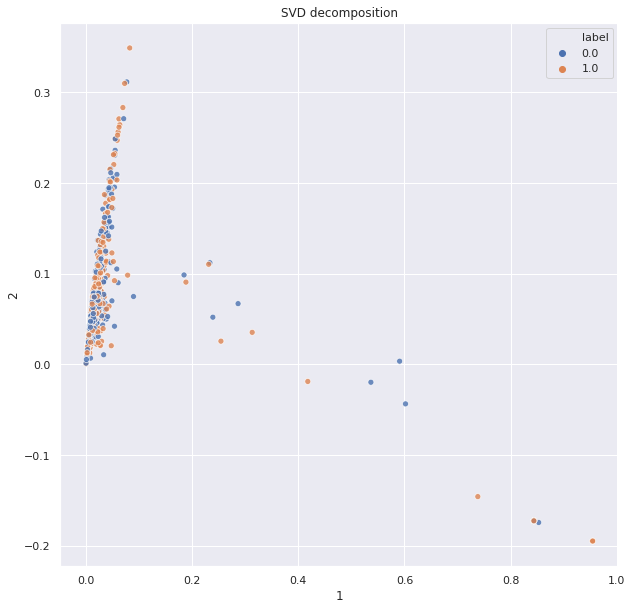

In [26]:
n_components = 2
title = "SVD decomposition"
# Creation of the model
mod = TruncatedSVD(n_components=n_components)
# Fit and transform the features
principal_components = mod.fit_transform(X)

# Put them into a dataframe
df_features = pd.DataFrame(data=principal_components,
                 columns=['1', '2'])

df_features['label'] = y

# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x='1',
                y='2',
                hue="label", 
                data=df_features,
                alpha=.8).set_title(title);

## Data balancing

In [27]:
if 'smote' in experiment:
    #oversampling with SMOTE
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
elif 'undersampling' in experiment:
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
elif 'random_oversampling' in experiment:
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
X_train.shape

(4946, 336461)

In [28]:
vocab_size = X_train.shape[1]
vocab_size

336461

## Metrics

In [29]:
#metrics
scenario = []
model = []
accuracy_score = []
precision_score = []
precision_score_neg = []
recall_score = []
recall_score_neg = []
f1_score = []
f1_score_neg = []
auc_score = []

## Models training and test

Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       618
           1       0.69      0.84      0.75       439

    accuracy                           0.77      1057
   macro avg       0.77      0.78      0.77      1057
weighted avg       0.79      0.77      0.77      1057

AUC:  0.8609741174042211


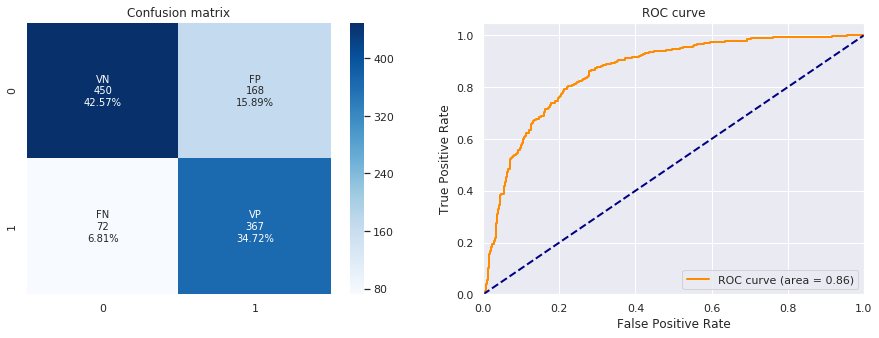

In [30]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
model.append('logistic regression')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       618
           1       0.91      0.29      0.44       439

    accuracy                           0.69      1057
   macro avg       0.78      0.64      0.62      1057
weighted avg       0.76      0.69      0.65      1057

AUC:  0.8403992598653899


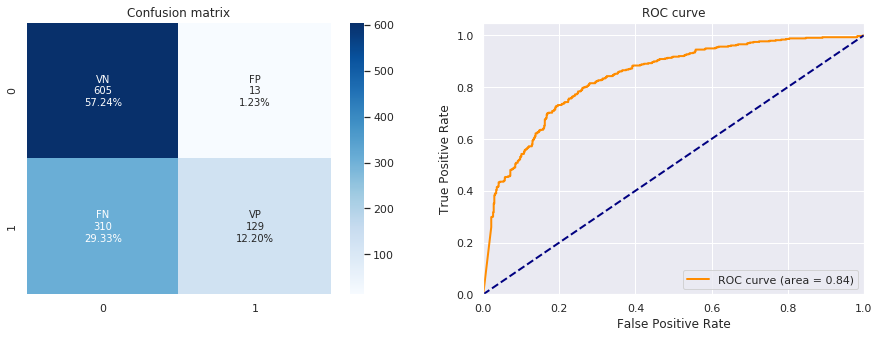

In [31]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
model.append('bernoulli naive-bayes')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Multinomial Naive-Bayes
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       618
           1       0.58      0.93      0.71       439

    accuracy                           0.69      1057
   macro avg       0.74      0.72      0.69      1057
weighted avg       0.77      0.69      0.68      1057

AUC:  0.8688546343189507


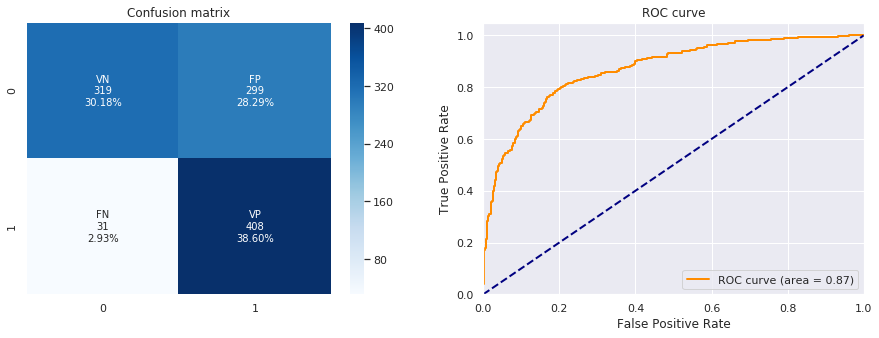

In [32]:
print('Multinomial Naive-Bayes')
mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_prob = mnb.predict_proba(X_test)[:,1]
model.append('multinomial naive-bayes')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       618
           1       0.74      0.81      0.77       439

    accuracy                           0.80      1057
   macro avg       0.80      0.80      0.80      1057
weighted avg       0.81      0.80      0.80      1057



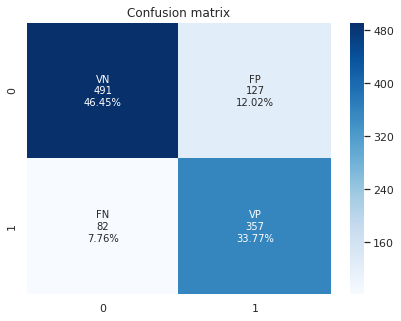

In [33]:
print('Linear Support Vector Machine')
svm = LinearSVC(dual=False).fit(X_train, y_train)
y_pred = svm.predict(X_test)
model.append('linear svm')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Linear SVM with SGD training.
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       618
           1       0.73      0.80      0.76       439

    accuracy                           0.80      1057
   macro avg       0.79      0.80      0.79      1057
weighted avg       0.80      0.80      0.80      1057



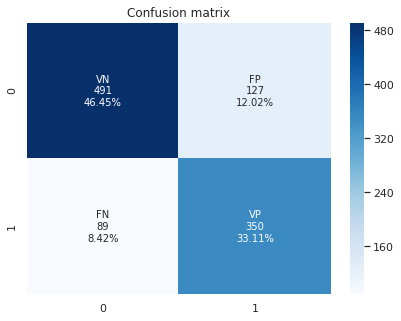

In [34]:
print('Linear SVM with SGD training.')
sgd = SGDClassifier().fit(X_train, y_train)
y_pred = sgd.predict(X_test)
#y_pred = 1 - y_pred ###wtf????
#y_prob = sgd.predict_proba(X_test)[:,1]
model.append('sgd')

acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, full_metrics = True)

accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

KNN
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       618
           1       0.70      0.60      0.65       439

    accuracy                           0.73      1057
   macro avg       0.72      0.71      0.71      1057
weighted avg       0.73      0.73      0.72      1057

AUC:  0.7961109759603688


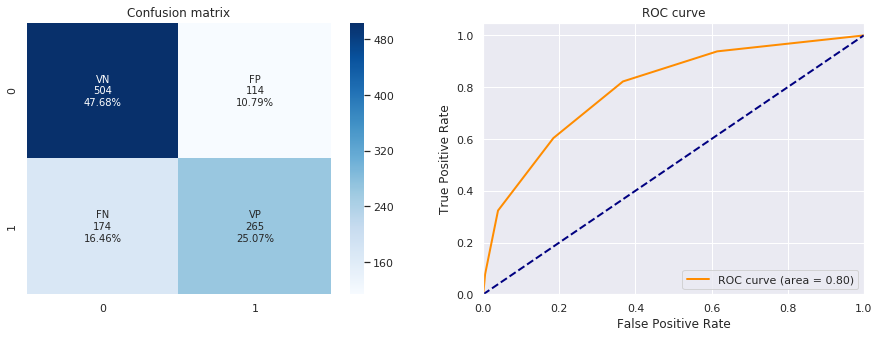

In [35]:
print('KNN')
#knn = KNeighborsClassifier(n_neighbors=15,weights='distance',n_jobs=-1).fit(X_train, y_train)
knn = KNeighborsClassifier(n_jobs=-1).fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]
model.append('knn')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

In [2]:
print('Random Forest')
rf = MLPClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
model.append('random forest')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Random Forest


NameError: name 'MLPClassifier' is not defined

Gradient Boosting
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       618
           1       0.72      0.69      0.70       439

    accuracy                           0.76      1057
   macro avg       0.75      0.75      0.75      1057
weighted avg       0.76      0.76      0.76      1057

AUC:  0.8350859927313472


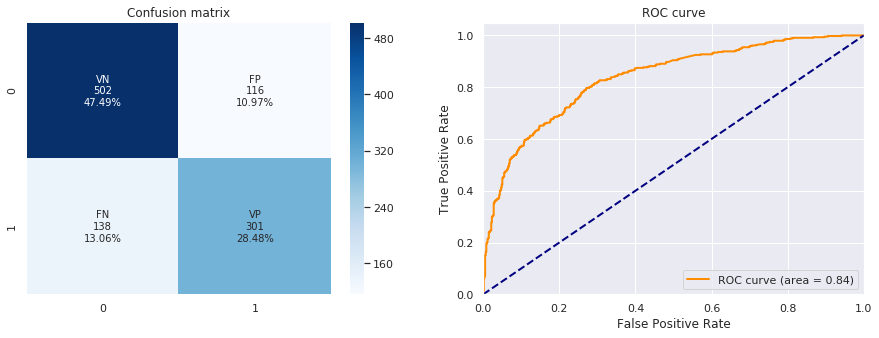

In [37]:
print('Gradient Boosting')
gb = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
model.append('gradient boosting')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

Multilayer perceptron
Iteration 1, loss = 0.66313935
Validation score: 0.630303
Iteration 2, loss = 0.46064994
Validation score: 0.775758
Iteration 3, loss = 0.27837233
Validation score: 0.840404
Iteration 4, loss = 0.16320287
Validation score: 0.846465
Iteration 5, loss = 0.10089971
Validation score: 0.830303


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.83      0.83      0.83       618
           1       0.76      0.76      0.76       439

    accuracy                           0.80      1057
   macro avg       0.80      0.80      0.80      1057
weighted avg       0.80      0.80      0.80      1057

AUC:  0.8727654053416488


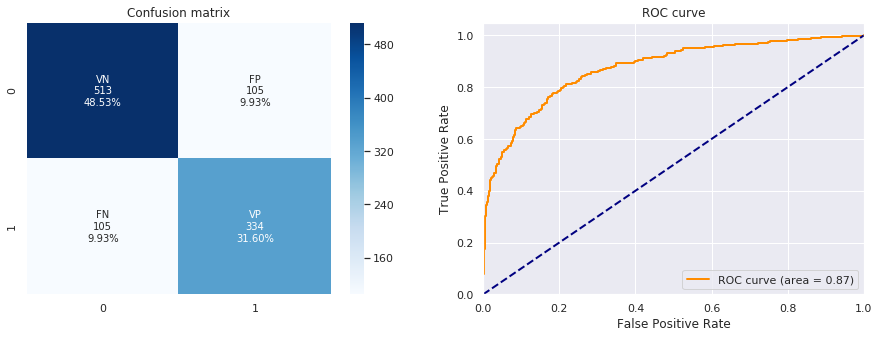

In [38]:
print('Multilayer perceptron')
mlp = MLPClassifier(max_iter = 5, verbose=True, early_stopping= True).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
model.append('mlp')
acc, precision, precision_neg, recall, recall_neg, f1, f1_neg, roc_auc = getTestMetrics(y_test, y_pred, y_prob, full_metrics = True)
accuracy_score.append(acc)
precision_score.append(precision)
precision_score_neg.append(precision_neg)
recall_score.append(recall)
recall_score_neg.append(recall_neg)
f1_score.append(f1)
f1_score_neg.append(f1_neg)
auc_score.append(roc_auc)

In [39]:
end_time = time.time()
ellapsed_time = end_time - start_time
print('ellapsed time (min):', ellapsed_time/60)

ellapsed time (min): 6.1161217053731285


## Results

In [40]:
df_metrics = pd.DataFrame({'model':model,                                 
                                 'vocab':[vocab_size]*len(model),
                                 'auc score': auc_score,
                                 'accuracy':accuracy_score,
                                 'precision 1': precision_score,
                                 'recall 1': recall_score,
                                 'f1 score 1': f1_score,
                                 'precision 0': precision_score_neg,
                                 'recall 0': recall_score_neg,                                 
                                 'f1 score 0': f1_score_neg
                                 })

df_metrics['precision avg'] = (df_metrics['precision 1'] + df_metrics['precision 0'])/2
df_metrics['recall avg'] = (df_metrics['recall 1'] + df_metrics['recall 0'])/2
df_metrics['f1 avg'] = (df_metrics['f1 score 1'] + df_metrics['f1 score 0'])/2

df_metrics

,model,vocab,auc score,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,precision avg,recall avg,f1 avg
0,logistic regression,336461,0.860974,0.772942,0.685981,0.835991,0.753593,0.789474,0.789474,0.789474,0.737727,0.812732,0.771534
1,bernoulli naive-bayes,336461,0.840399,0.694418,0.908451,0.293850,0.444062,0.789302,0.789302,0.789302,0.848876,0.541576,0.616682
2,multinomial naive-bayes,336461,0.868855,0.687796,0.577086,0.929385,0.712042,0.659091,0.659091,0.659091,0.618089,0.794238,0.685566
3,linear svm,336461,0.000000,0.802271,0.737603,0.813212,0.773564,0.824517,0.824517,0.824517,0.781060,0.818865,0.799041
4,sgd,336461,0.000000,0.795648,0.733753,0.797267,0.764192,0.819699,0.819699,0.819699,0.776726,0.808483,0.791946
5,knn,336461,0.796111,0.727531,0.699208,0.603645,0.647922,0.777778,0.777778,0.777778,0.738493,0.690711,0.712850
6,random forest,336461,0.852751,0.773888,0.847222,0.555809,0.671252,0.827686,0.827686,0.827686,0.837454,0.691747,0.749469
7,gradient boosting,336461,0.835086,0.759697,0.721823,0.685649,0.703271,0.798092,0.798092,0.798092,0.759957,0.741871,0.750682
8,mlp,336461,0.872765,0.801325,0.760820,0.760820,0.760820,0.830097,0.830097,0.830097,0.795459,0.795459,0.795459


In [41]:
filepath = 'results/' + base + '/' + subset + '/ml/' + experiment + '.csv'
filepath

'results/2018/viral/ml/ml-tfidf-unibitri_gram-random_oversampling.csv'

In [42]:
df_metrics.to_csv(filepath, index = False)

In [43]:
df_metrics = pd.read_csv(filepath)
df_metrics

,model,vocab,auc score,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,precision avg,recall avg,f1 avg
0,logistic regression,336461,0.860974,0.772942,0.685981,0.835991,0.753593,0.789474,0.789474,0.789474,0.737727,0.812732,0.771534
1,bernoulli naive-bayes,336461,0.840399,0.694418,0.908451,0.293850,0.444062,0.789302,0.789302,0.789302,0.848876,0.541576,0.616682
2,multinomial naive-bayes,336461,0.868855,0.687796,0.577086,0.929385,0.712042,0.659091,0.659091,0.659091,0.618089,0.794238,0.685566
3,linear svm,336461,0.000000,0.802271,0.737603,0.813212,0.773564,0.824517,0.824517,0.824517,0.781060,0.818865,0.799041
4,sgd,336461,0.000000,0.795648,0.733753,0.797267,0.764192,0.819699,0.819699,0.819699,0.776726,0.808483,0.791946
5,knn,336461,0.796111,0.727531,0.699208,0.603645,0.647922,0.777778,0.777778,0.777778,0.738493,0.690711,0.712850
6,random forest,336461,0.852751,0.773888,0.847222,0.555809,0.671252,0.827686,0.827686,0.827686,0.837454,0.691747,0.749469
7,gradient boosting,336461,0.835086,0.759697,0.721823,0.685649,0.703271,0.798092,0.798092,0.798092,0.759957,0.741871,0.750682
8,mlp,336461,0.872765,0.801325,0.760820,0.760820,0.760820,0.830097,0.830097,0.830097,0.795459,0.795459,0.795459


# Best results

In [44]:
results_dir = 'results/' + str(base) + '/' + subset + '/ml/'
results_dir

'results/2018/viral/ml/'

In [45]:
# best results analysis
df_best = pd.DataFrame(columns=df_metrics.columns)

#iterates over files
exp = []
for filename in os.listdir(results_dir):
    exp.append(str(filename).replace('.csv',''))
    file_path = results_dir + filename
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp['f1 score 1'].argmax() #f1 score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
    #df_best = df_best.append(df_temp[df_temp['model']=='knn'])
    
df_best['vocab'] = df_best['vocab'].astype('int64')    
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_best = df_best[cols]

df_best = df_best.sort_values(by='f1 score 1',ascending=False)
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best.style.background_gradient(cmap='Blues')

,experiment,model,vocab,auc score,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,precision avg,recall avg,f1 avg
0,ml-tfidf-unibitri_gram-random_oversampling,linear svm,336461,0.000000,0.802271,0.737603,0.813212,0.773564,0.824517,0.824517,0.824517,0.781060,0.818865,0.799041
1,ml-tfidf-unibi_gram-random_oversampling,linear svm,153404,0.000000,0.804163,0.755507,0.781321,0.768197,0.830467,0.830467,0.830467,0.792987,0.805894,0.799332
2,ml-tfidf-unibitriquad_gram-processed-random_oversampling,sgd,258073,0.000000,0.789026,0.723140,0.797267,0.758397,0.812762,0.812762,0.812762,0.767951,0.805014,0.785579
3,ml-tfidf-unibitri_gram-processed-random_oversampling,linear svm,258073,0.000000,0.787133,0.718367,0.801822,0.757804,0.810127,0.810127,0.810127,0.764247,0.805974,0.783965
4,ml-tfidf-bigram-random_oversampling,linear svm,129097,0.000000,0.798486,0.766509,0.740319,0.753187,0.829736,0.829736,0.829736,0.798123,0.785028,0.791461
5,ml-tfidf-undersampling,random forest,24307,0.860897,0.793756,0.761229,0.733485,0.747100,0.825879,0.825879,0.825879,0.793554,0.779682,0.786489
6,ml-bow-unibitri_gram-random_oversampling,logistic regression,336461,0.873333,0.806055,0.821429,0.681093,0.744707,0.843631,0.843631,0.843631,0.832530,0.762362,0.794169
7,ml-tfidf-processed-smote,linear svm,21173,0.000000,0.789972,0.754098,0.733485,0.743649,0.822115,0.822115,0.822115,0.788107,0.777800,0.782882
8,ml-bow-processed-random_oversampling,logistic regression,21173,0.848567,0.794702,0.773399,0.715262,0.743195,0.828999,0.828999,0.828999,0.801199,0.772131,0.786097
9,ml-bow-random_oversampling-processed,logistic regression,21173,0.848567,0.794702,0.773399,0.715262,0.743195,0.828999,0.828999,0.828999,0.801199,0.772131,0.786097


In [46]:
df_best['model'].value_counts()

linear svm                 10
random forest               6
sgd                         3
logistic regression         3
mlp                         2
multinomial naive-bayes     1
Name: model, dtype: int64

In [51]:
exp = sorted(list(df_best['experiment']))
for e in exp:
    print(e + ', ',end='')

ml-bow, ml-bow-processed, ml-bow-processed-random_oversampling, ml-bow-processed-random_oversampling-max_features, ml-bow-processed-smote, ml-bow-random_oversampling, ml-bow-random_oversampling-max_features, ml-bow-random_oversampling-processed, ml-bow-unibitri_gram-processed-random_oversampling, ml-bow-unibitri_gram-random_oversampling, ml-tfidf, ml-tfidf-bigram-random_oversampling, ml-tfidf-processed, ml-tfidf-processed-random_oversampling, ml-tfidf-processed-random_oversampling-max_features, ml-tfidf-processed-smote, ml-tfidf-random_oversampling, ml-tfidf-random_oversampling-max_features, ml-tfidf-smote, ml-tfidf-trigram-random_oversampling, ml-tfidf-undersampling, ml-tfidf-unibi_gram-random_oversampling, ml-tfidf-unibitri_gram-processed-random_oversampling, ml-tfidf-unibitri_gram-random_oversampling, ml-tfidf-unibitriquad_gram-processed-random_oversampling, 

In [47]:
print('total experiments:',len(df_best)*len(df_metrics))

total experiments: 225


## Best results with twitter

In [93]:
results_dir_twitter = 'results/2018/viral/ml twitter/'
results_dir_twitter

'results/2018/viral/ml twitter/'

In [95]:
# best results analysis
df_best = pd.DataFrame(columns=df_metrics.columns)

#iterates over files
exp = []
for filename in os.listdir(results_dir_twitter):
    exp.append(str(filename).replace('.csv',''))
    file_path = results_dir_twitter + filename
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp['f1 avg'].argmax() #f1 score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
    
df_best['vocab'] = df_best['vocab'].astype('int64')    
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_best = df_best[cols]

df_best = df_best.sort_values(by='f1 avg',ascending=False)
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best.style.background_gradient(cmap='Blues')

,experiment,model,vocab,auc score,accuracy,precision 1,recall 1,f1 score 1,precision 0,recall 0,f1 score 0,precision avg,recall avg,f1 avg
0,ml-bow-processed,linear svm,2411,0.000000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
1,ml-bow-processed-random_oversampling-max_features,random forest,500,0.760417,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
2,ml-bow-random_oversampling,linear svm,2411,0.000000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
3,ml-bow,linear svm,2411,0.000000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
4,ml-bow-random_oversampling-max_features,random forest,500,0.750000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
5,ml-bow-processed-random_oversampling,linear svm,2411,0.000000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
6,ml-bow-random_oversampling-processed,linear svm,2411,0.000000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
7,ml-tfidf,sgd,2411,0.000000,0.850000,0.846154,0.916667,0.880000,0.800000,0.800000,0.800000,0.823077,0.858333,0.840000
8,ml-tfidf-undersampling,linear svm,2411,0.000000,0.800000,0.900000,0.750000,0.818182,0.777778,0.777778,0.777778,0.838889,0.763889,0.797980
9,ml-tfidf-smote,sgd,2411,0.000000,0.800000,0.785714,0.916667,0.846154,0.714286,0.714286,0.714286,0.750000,0.815476,0.780220


# Error examples with best classifier

In [37]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_pred = svm.predict(X_test)
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  82
False positive:  127


In [38]:
full_texts_test = list(full_texts_test)

In [39]:
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

### False negative

In [40]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Gente Apenas Minha Opinião então Vamos lá

No Dia 06 de Junho TSE Derruba o Voto Impresso de Autoria do deputado Federal Candidato a presidente Jair Bolsonaro

No Dia 06 de Setembro Jair Bolsonaro Sofre um Atentado que Seria pra MATAR

Um Dia Antes da Eleição Dia 06; Coincidência Se Juntar as Datas dar Certos 666 
Agora Bolsonaro corre novo Risco...

A que Interessa Isso ? Nova Ordem Mundial / Marconaria ? / iluminati ? / 
Peço que Compartilhem 
E Faca Chegar ao Bolsonaro

Breno Washington MG
Juntos somos fortes
***
***
Escuta a fala sensata e inteligente do Miguel Falabella.
👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻
***
***
A morte da velha política no Brasil, comentário de Alexandre Garcia.👇🏻👇🏻👇🏻
***
***
Vou mandar uns vídeos aí, isso tem que rodar o Brasil, mostrar pra petistas o que realmente impediu bolsonaro de ganhar no primeiro turno, e põe em grande risco o segundo turno.👇
***
***
Todo mundo viu o carro bomba né???
***
***
ATENÇÃO: PAULO GUEDES 
Hoje 17/set/18, Paulo Guedes Ministro da Fazen

### False positives

In [40]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
TEXTO DA FUNDADORA DO DIRETÓRIO DO PT EM ARACAJU

Esquerda brasileira, chega de apontar culpados! Está na hora de assumir o ocorrido e partir prum mea culpa já!, antes que os Dórias e Bolssonaros assumam o poder! Quem elegeu Temer não foram os coxinhas. Parem de tergiversar. Temer foi eleito por vocês com dinheiro público desviado de hospitais, creches e escolas! O resto é retórica, ou ilação como vocês agora costumam chamar o que nós brasileiros conhecemos como mentira!

A arrogância da esquerda de acreditar que lida com tolos e que porta o Santo Graal está no pano de fundo de sua derrocada mundo afora.

Vamos fazer diferente e lavar a jato essa roupa suja antes que seja tarde! A máscara caiu!

Um homem que responsabiliza a companheira morta para não assumir seus atos é um covarde e não herói . Essa inversão de valores para mim é assustadora...

E não me venham falar da corrupção que existe desde a época de CABRAL que não somos trouxinhas...Nós militamos no PT e construímos esse 

# Tunning

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# KNN tunning

In [35]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [3,5,9,15,25,35], 'weights': ['uniform','distance']}]

In [38]:
clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), tuned_parameters, scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid=[{'n_neighbors': [3, 5, 9, 15, 25, 35],
                          'weights': ['uniform', 'distance']}],
             scoring='f1')

In [39]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'n_neighbors': 3, 'weights': 'distance'}

Grid scores on development set:

0.703 (+/-0.077) for {'n_neighbors': 3, 'weights': 'uniform'}
0.790 (+/-0.132) for {'n_neighbors': 3, 'weights': 'distance'}
0.693 (+/-0.057) for {'n_neighbors': 5, 'weights': 'uniform'}
0.787 (+/-0.105) for {'n_neighbors': 5, 'weights': 'distance'}
0.709 (+/-0.023) for {'n_neighbors': 9, 'weights': 'uniform'}
0.786 (+/-0.082) for {'n_neighbors': 9, 'weights': 'distance'}
0.719 (+/-0.034) for {'n_neighbors': 15, 'weights': 'uniform'}
0.780 (+/-0.069) for {'n_neighbors': 15, 'weights': 'distance'}
0.726 (+/-0.021) for {'n_neighbors': 25, 'weights': 'uniform'}
0.770 (+/-0.051) for {'n_neighbors': 25, 'weights': 'distance'}
0.729 (+/-0.018) for {'n_neighbors': 35, 'weights': 'uniform'}
0.767 (+/-0.042) for {'n_neighbors': 35, 'weights': 'distance'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full e

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       618
           1       0.78      0.57      0.66       439

    accuracy                           0.76      1057
   macro avg       0.76      0.73      0.74      1057
weighted avg       0.76      0.76      0.75      1057



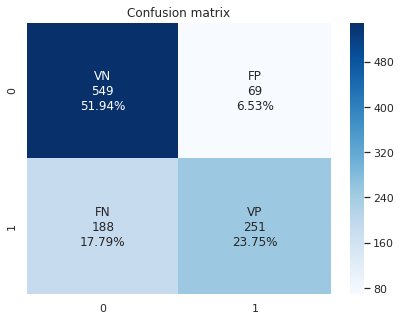

In [41]:
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

# SVM tunning

In [42]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(SVC(), tuned_parameters, scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='f1')

In [43]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.402 (+/-0.656) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.402 (+/-0.656) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.692 (+/-0.056) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.402 (+/-0.656) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.710 (+/-0.093) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.692 (+/-0.057) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.832 (+/-0.091) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.711 (+/-0.092) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.829 (+/-0.094) for {'C': 1, 'kernel': 'linear'}
0.831 (+/-0.093) for {'C': 10, 'kernel': 'linear'}
0.830 (+/-0.100) for {'C': 100, 'kernel': 'linear'}
0.829 (+/-0.112) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       618
           1       0.73      0.80      0.76       439

    accuracy                           0.79      1057
   macro avg       0.79      0.80      0.79      1057
weighted avg       0.80      0.79      0.80      1057



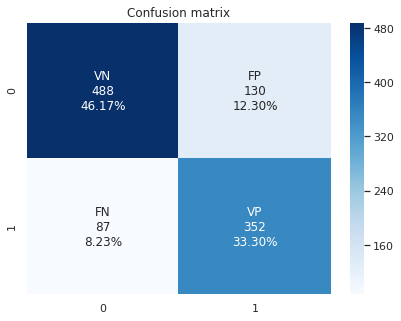

In [44]:
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

# GradientBoosting tunning

In [49]:
# Set the parameters by cross-validation
# tuned_parameters = [{'n_estimators': [100, 500, 1000],
#                     'subsample':[1.0,0.8,0.5],
#                     'max_depth':[1,5,10]}]

tuned_parameters = [{'n_estimators': [100, 500, 1000]}]

clf = GridSearchCV(GradientBoostingClassifier(verbose=True), tuned_parameters, scoring='f1')
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3615            1.96m
         2           1.3408            1.84m
         3           1.3231            1.81m
         4           1.3079            1.75m
         5           1.2947            1.72m
         6           1.2810            1.69m
         7           1.2702            1.67m
         8           1.2591            1.64m
         9           1.2482            1.62m
        10           1.2385            1.60m
        20           1.1641            1.43m
        30           1.1135            1.30m
        40           1.0753            1.12m
        50           1.0444           55.64s
        60           1.0162           44.26s
        70           0.9908           32.85s
        80           0.9701           22.15s
        90           0.9477           11.13s
       100           0.9311            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3623            2.25m
        

KeyboardInterrupt: 

In [48]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
print("Detailed classification report:")   
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)
acc, precision, recall, f1, roc_auc

Best parameters set found on development set:



AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# MLP Hyperparameter tunning with random search

In [73]:
def randomLayers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(10,300)
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

       
print(randomLayers())
    

(139, 21)


## Hyperparameters

MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)[source].

In [ ]:
validation_mlp = True
if validation_mlp:
    hyperparams = []
    best_hyperpams = []
    results = []
    n_iter = 20
    best_score = 0
    np.random.seed(42)

    activation_list = ['logistic', 'tanh', 'relu']
    solver_list = ['sgd', 'adam', 'lbfgs']
    learning_rate_list = ['constant'] #,'adaptive']

    for i in range(n_iter):
        print(str(i+1) + '/' + str(n_iter))

        # hidden layers
        hidden_layer_sizes = randomLayers()

        #activation
        s = np.random.randint(len(activation_list))
        activation = activation_list[s]

        #solver
        s = np.random.randint(len(solver_list))
        solver = solver_list[s]

        #alpha
        s = np.random.uniform(-4,-0.5)
        alpha = 10**s

        #learning rate
        s = np.random.randint(len(learning_rate_list))
        learning_rate = learning_rate_list[s]

        # max of iterations during training
        max_iter = np.random.randint(5,20) 

        hyperparams.append([hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter])

        print('training: ')
        print(hyperparams[i])

        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                            activation=activation, 
                            solver=solver, 
                            alpha=alpha, 
                            learning_rate=learning_rate, 
                            max_iter = max_iter,
                            verbose=True, early_stopping= True, 
                            n_iter_no_change = 5).fit(X_train_val, y_train_val)

        y_pred = mlp.predict(X_val)
        y_prob = mlp.predict_proba(X_val)[:,1]    
        score = metrics.f1_score(y_val, y_pred, pos_label = 1, average = 'binary')
        results.append(score)

        if score > best_score:
            best_score = score
            best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]  


    val_data = list(zip(results,hyperparams))    
    val_data = sorted(val_data, key=lambda tup: tup[0],reverse = True)
    val_data 

1/20
training: 
[(280, 116, 81), 'logistic', 'sgd', 0.0003516132573873206, 'constant', 7]
Iteration 1, loss = 0.69398171
Validation score: 0.500000
Iteration 2, loss = 0.69358224
Validation score: 0.500000
Iteration 3, loss = 0.69348013
Validation score: 0.500000
Iteration 4, loss = 0.69348689
Validation score: 0.500000
Iteration 5, loss = 0.69356658
Validation score: 0.500000
Iteration 6, loss = 0.69368508
Validation score: 0.500000
Iteration 7, loss = 0.69376737
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
2/20
training: 
[(258, 252, 154), 'tanh', 'adam', 0.00011588129385793504, 'constant', 11]
Iteration 1, loss = 0.53629835
Validation score: 0.816143
Iteration 2, loss = 0.03943818
Validation score: 0.802691
Iteration 3, loss = 0.03167787
Validation score: 0.755605
Iteration 4, loss = 0.01886427
Validation score: 0.802691
Iteration 5, loss = 0.00728180
Validation score: 0.804933
Iteration 6, loss = 0.00598565
V

In [1]:
#best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]
hidden_layer_sizes = best_hyperpams[0]
activation = best_hyperpams[1]
solver = best_hyperpams[2]
alpha = best_hyperpams[3]
learning_rate = best_hyperpams[4]
max_iter = best_hyperpams[5]
best_hyperpams

NameError: name 'best_hyperpams' is not defined

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                    activation=activation, 
                    solver=solver, 
                    alpha=alpha, 
                    learning_rate=learning_rate, 
                    max_iter = max_iter,
                    verbose=True, early_stopping= True, 
                    n_iter_no_change = 5).fit(X_train, y_train)

In [ ]:
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

In [ ]:
print([acc, precision, recall, f1, roc_auc])